# Setting up

In [35]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 50)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report, roc_auc_score
from sklearn.metrics import auc,roc_curve, RocCurveDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


import imblearn
from imblearn.pipeline import Pipeline as imbpipeline

import time
import os

In [2]:
df_original = pd.read_csv('cs-training.csv').drop(columns='Unnamed: 0')
df_original['SeriousDlqin2yrs'] = 1 - df_original['SeriousDlqin2yrs'] #1 is now good, 0 is bad

In [3]:
df_original.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
df_original['SeriousDlqin2yrs'].sum()

139974

In [6]:
df_original.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.933160,0.249746,0.0,1.000000,1.000000,1.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


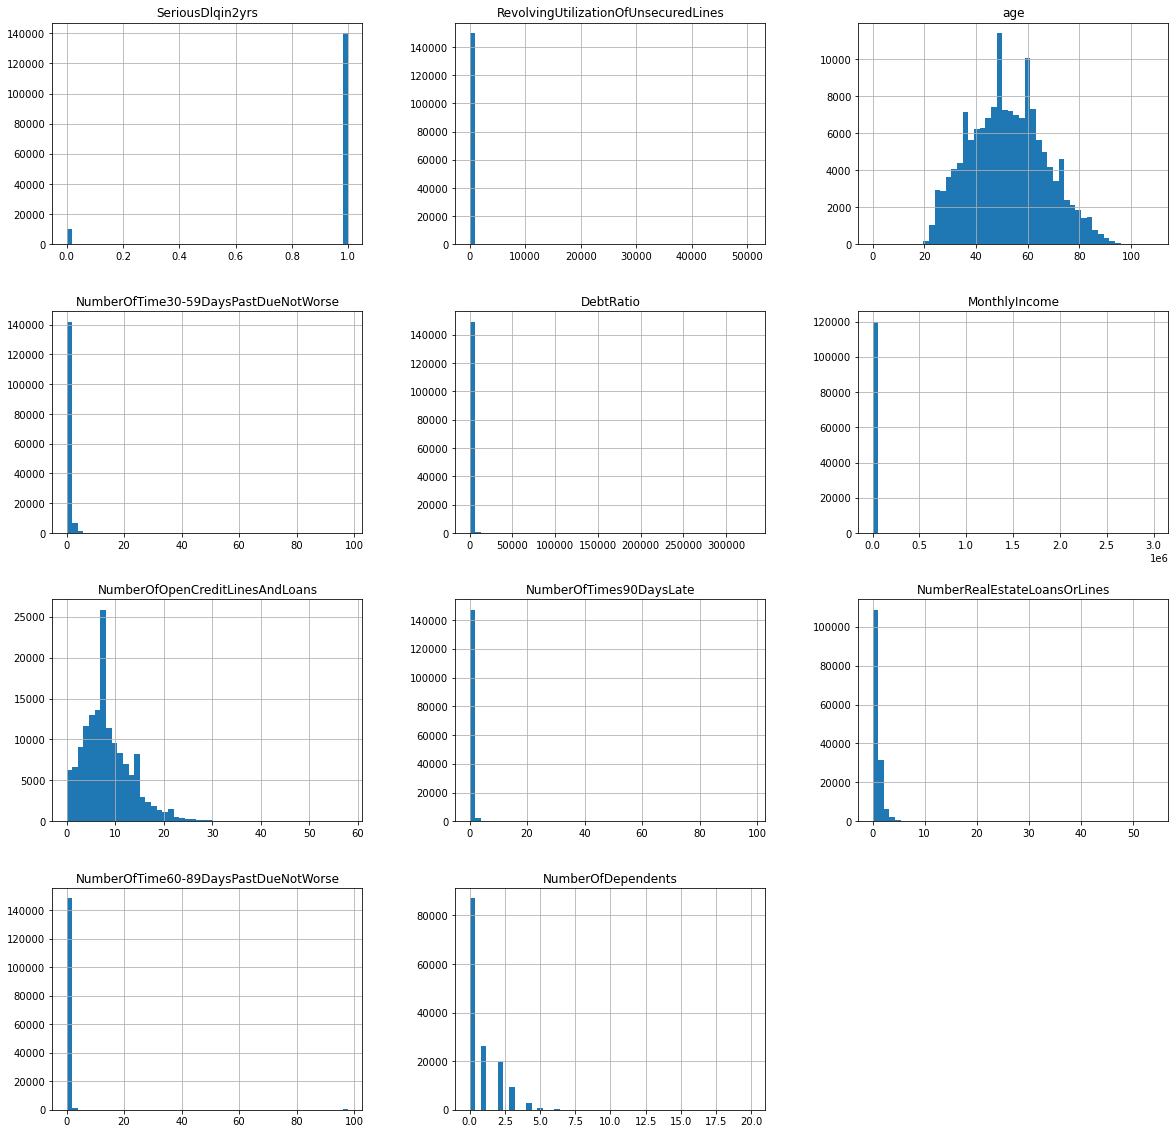

In [7]:
df_original.hist(figsize = (20,20), bins = 50)
plt.show()

## Utilities functions

In [5]:
def impute(df, col, method = 'median'):
    if method == 'median':
        imputed_value = df[col].median()
    else:
        imputed_value = df[col].mean()
    df[col] = df[col].fillna(imputed_value)

def clip_col(df, col, quantile = 0.99, mark_clipped = True):
    if col == 'DebtRatio':
        quantile = 0.7
    quantile_value = df[col].quantile(quantile)
    if mark_clipped:
        new_col_name = col + '_is_clipped'
        df[new_col_name] = np.where(df[col]>quantile_value,1,0)
    df[col] = np.where(df[col]>quantile_value, quantile_value, df[col])

def bin_ohe(df, col, n_cut = 4):
    labels = [f'{col}_{i}' for i in range(1,5)]
    df[col] = pd.qcut(df[col], n_cut, labels=labels)
    ohe = OneHotEncoder()
    ohe_df = pd.DataFrame(ohe.fit_transform(df[[col]]).toarray(), columns=labels)
    df[labels] = ohe_df
    df.drop(columns=col, inplace=True)
    
def ohe(df, col):
    one_hot = pd.get_dummies(df[col])
    df = df.drop(col,axis = 1)
    df = df.join(one_hot)
    return df

EPS = 1e-4

# Traditional model

In [14]:
df = copy.deepcopy(df_original)
df['Missing Income'] = df['MonthlyIncome'].isna().astype(int)
df['Missing Dependent'] = df['NumberOfDependents'].isna().astype(int)

impute(df, 'MonthlyIncome')
impute(df, 'NumberOfDependents')


cols_to_clip = [
                'RevolvingUtilizationOfUnsecuredLines',
                'NumberOfTime30-59DaysPastDueNotWorse',
                'DebtRatio',
                'MonthlyIncome',
                'NumberOfOpenCreditLinesAndLoans',
                'NumberOfTimes90DaysLate',
                'NumberRealEstateLoansOrLines',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfDependents',
                'age'
                ]
for col in cols_to_clip:
    clip_col(df, col)

cols_to_log = [
                'RevolvingUtilizationOfUnsecuredLines',
                'NumberOfTime30-59DaysPastDueNotWorse',
                'DebtRatio',
                'MonthlyIncome',
                'NumberOfTimes90DaysLate',
                'NumberRealEstateLoansOrLines',
                'NumberOfTime60-89DaysPastDueNotWorse',
                'NumberOfDependents',
                ]

for col in cols_to_log:
    df[col] = np.log(df[col] + EPS)

# taking nature log to reduce skewness
# df['MonthlyIncome'] = np.log(df['MonthlyIncome'])
# df['DebtRatio'] = np.log(df['DebtRatio'])
# df['NumberOfTimes90DaysLate'] = np.log(df['NumberOfTimes90DaysLate'])
# df['NumberRealEstateLoansOrLines'] = np.log(df['NumberRealEstateLoansOrLines'])
# df['NumberOfTime60-89DaysPastDueNotWorse'] = np.log(df['NumberOfTime60-89DaysPastDueNotWorse'])

In [15]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.933160,0.249746,0.00000,1.000000,1.000000,1.000000,1.000000
RevolvingUtilizationOfUnsecuredLines,150000.0,-2.505563,2.499267,-9.21034,-3.507644,-1.868981,-0.581344,0.088977
age,150000.0,52.265380,14.695878,0.00000,41.000000,52.000000,63.000000,87.000000
NumberOfTime30-59DaysPastDueNotWorse,150000.0,-7.688925,3.492493,-9.21034,-9.210340,-9.210340,-9.210340,1.386319
DebtRatio,150000.0,-1.575265,1.793601,-9.21034,-1.741976,-1.003463,-0.431877,-0.431877
MonthlyIncome,150000.0,8.339125,2.015503,-9.21034,8.269501,8.594154,8.909235,10.043249
NumberOfOpenCreditLinesAndLoans,150000.0,8.404000,4.946399,0.00000,5.000000,8.000000,11.000000,24.000000
NumberOfTimes90DaysLate,150000.0,-8.679899,2.188992,-9.21034,-9.210340,-9.210340,-9.210340,1.098646
NumberRealEstateLoansOrLines,150000.0,-3.224467,4.645185,-9.21034,-9.210340,0.000100,0.693197,1.386319
NumberOfTime60-89DaysPastDueNotWorse,150000.0,-8.734778,2.059057,-9.21034,-9.210340,-9.210340,-9.210340,0.693197


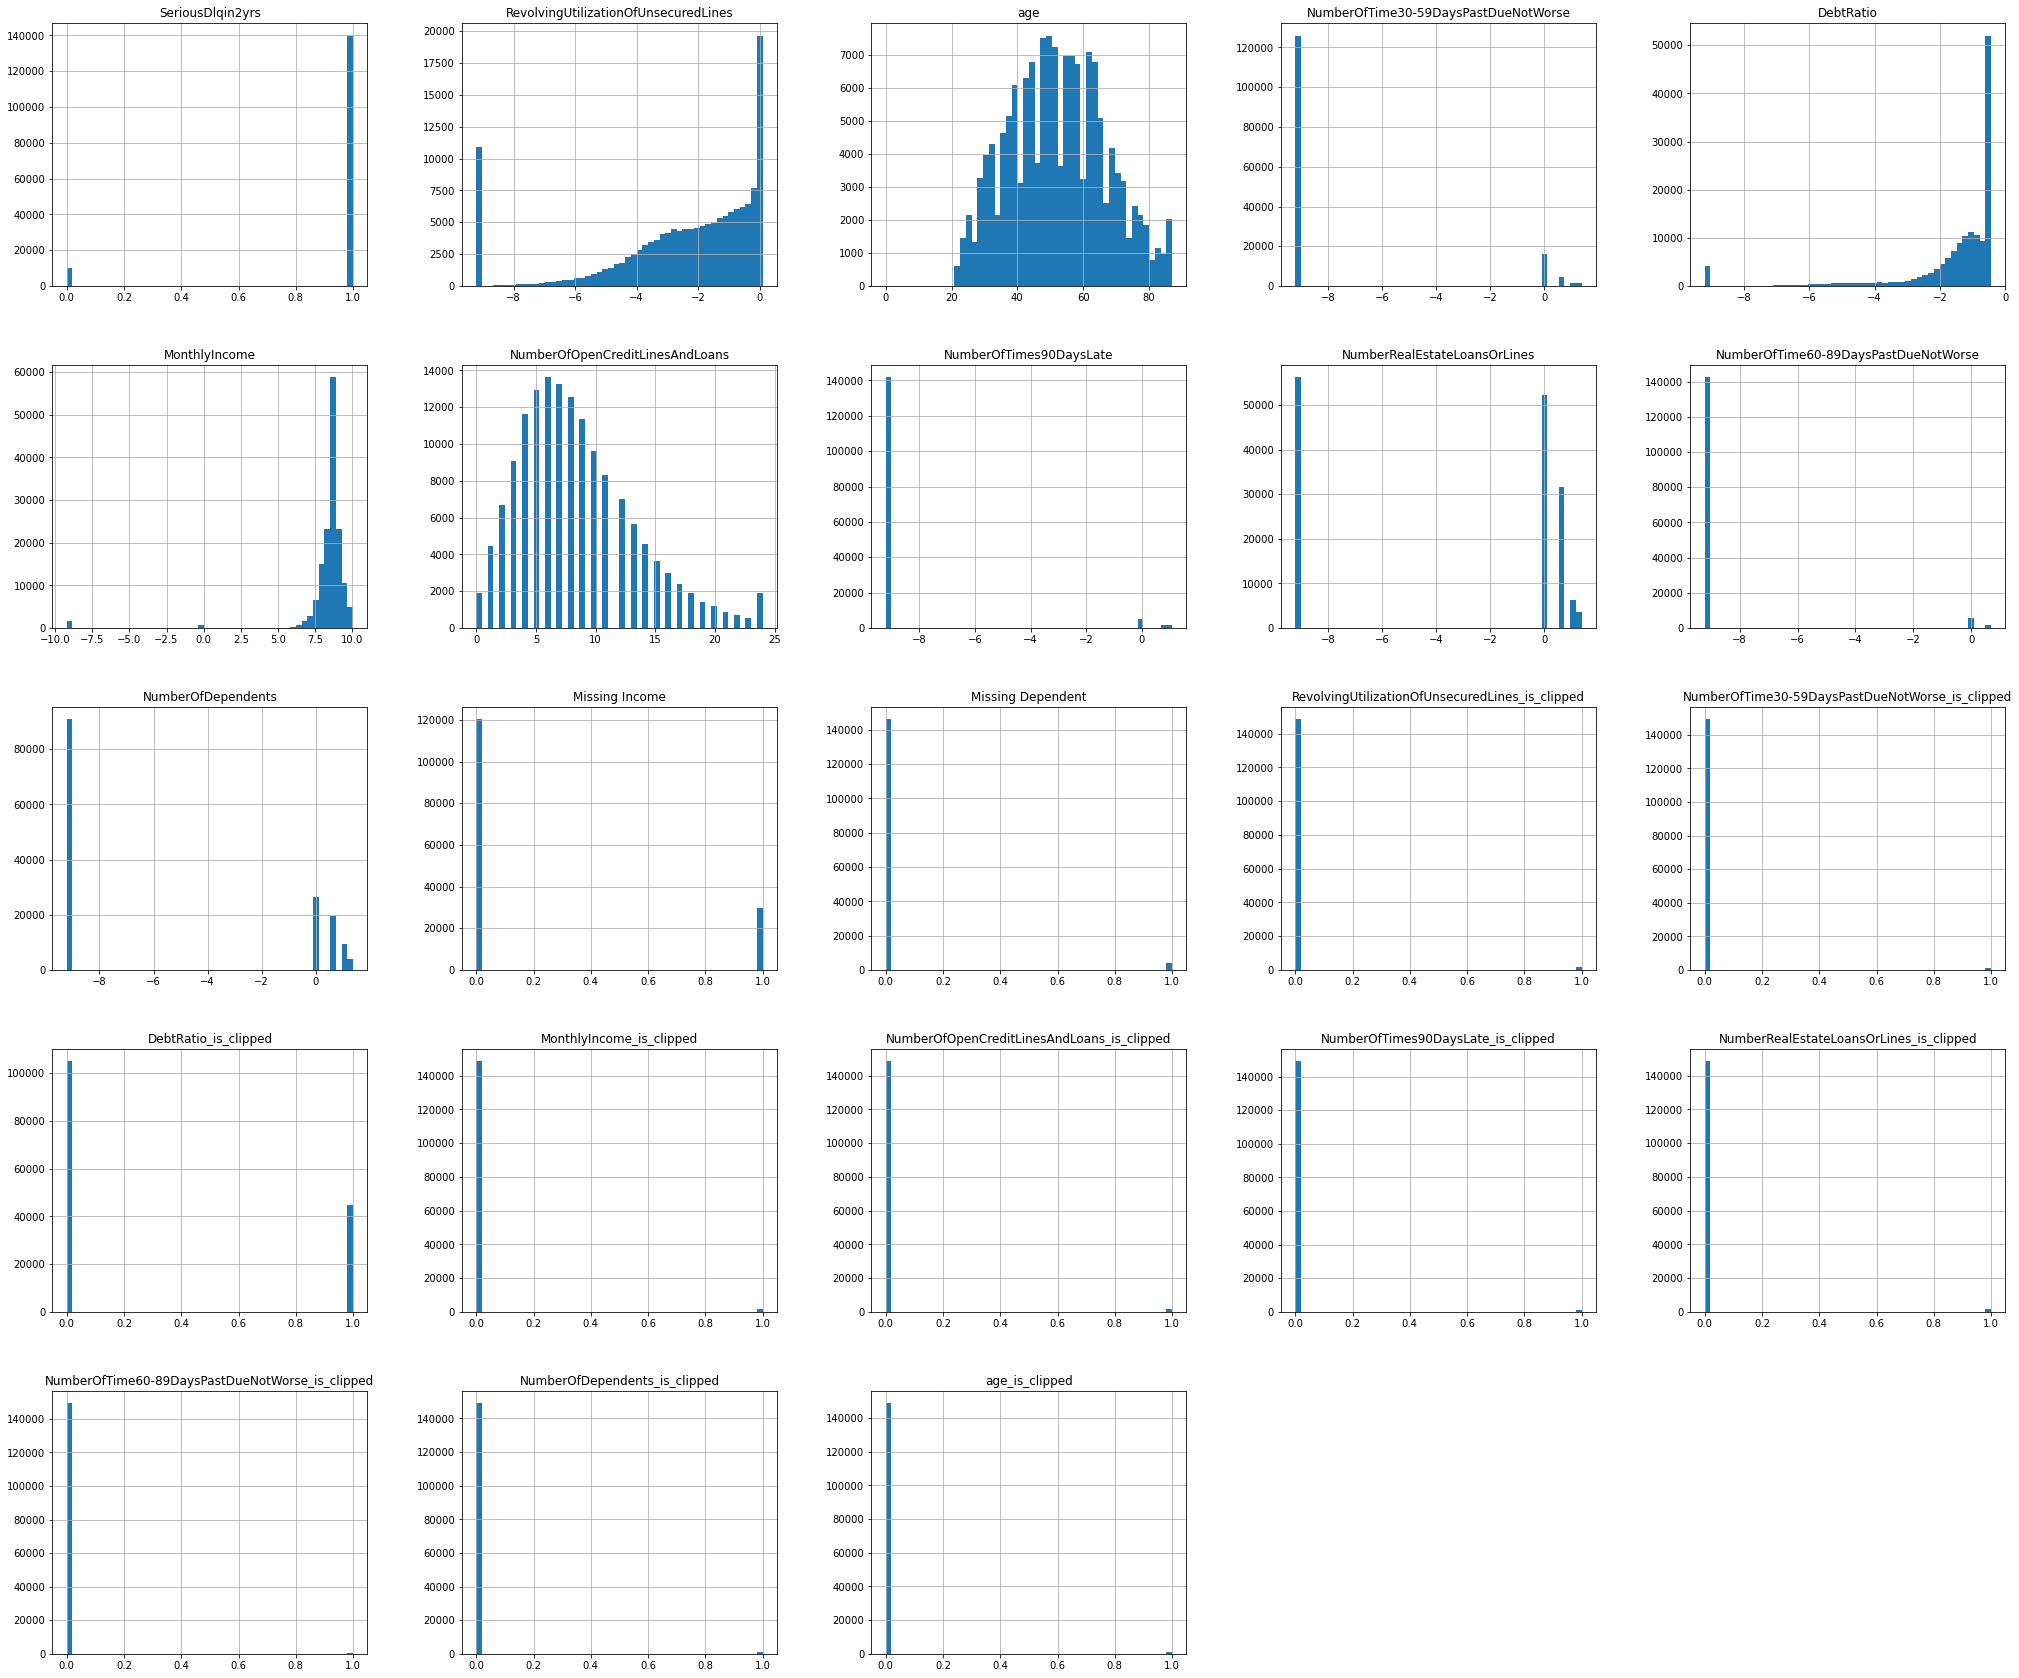

In [16]:
df.hist(figsize = (35,30), bins = 50)
plt.show()

In [17]:
X = df.iloc[:,1:]
y = df.iloc[:,0]

scaler = StandardScaler()
# scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [18]:
sampler = imblearn.over_sampling.SMOTE(sampling_strategy='minority')
# sampler = imblearn.over_sampling.RandomOverSampler(sampling_strategy='minority')
# sampler = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
X_over, y_over = sampler.fit_resample(X_train, y_train)


In [19]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'log2'],
    'max_depth': [4,5,6]
}
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True) 

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 4, scoring='roc_auc')
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

{'max_depth': 6, 'max_features': 'log2', 'n_estimators': 700}


In [305]:
# from hyperopt import hp, tpe, fmin

# space = {'n_estimators':hp.quniform('n_estimators', 10, 4000, 10),
#         'learning_rate':hp.uniform('learning_rate', 0.00001, 0.03),
#          'max_depth':hp.quniform('max_depth', 3,7,1),
#          'subsample':hp.uniform('subsample', 0.60, 0.95),
#          'colsample_bytree':hp.uniform('colsample_bytree', 0.60, 0.95),
#          'reg_lambda': hp.uniform('reg_lambda', 1, 20),
#         }

# def objective(params):
#     params = {'n_estimators': int(params['n_estimators']),
#              'learning_rate': params['learning_rate'],
#              'max_depth': int(params['max_depth']),
#              'subsample': params['subsample'],
#              'colsample_bytree': params['colsample_bytree'],
#              'reg_lambda': params['reg_lambda'],
#              }
    
#     lgbm= LGBMClassifier(**params)
#     cv = StratifiedKFold(5)
#     score = cross_val_score(lgbm, X_over, y_over, scoring='roc_auc', cv=cv, n_jobs=-1).mean()
#     return -score
# best = fmin(fn= objective, space= space, max_evals=20, rstate=np.random.RandomState(1), algo=tpe.suggest)
# import pickle

# # # store variables in pickle
# # start_time = time.time()
# # with open('best_params.pkl', 'wb') as f:
# #     pickle.dump(best, f)
# # print("--- %s seconds ---" % (time.time() - start_time))

# # read pickle
# start_time = time.time()
# with open('best_params.pkl', 'rb') as f:
#     best = pickle.load(f)
# print("--- %s seconds ---" % (time.time() - start_time))
# model = LGBMClassifier(random_state=0,
#                         n_estimators=int(best['n_estimators']), 
#                         colsample_bytree= best['colsample_bytree'],
#                         learning_rate= best['learning_rate'],
#                         max_depth= int(best['max_depth']),
#                         subsample= best['subsample'],
#                         reg_lambda= best['reg_lambda']
#                         # **best
#                        )


In [20]:
model = RandomForestClassifier(**CV_rfc.best_params_,n_jobs=-1, oob_score = True)
model.fit(X_over, y_over)

RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=700,
                       n_jobs=-1, oob_score=True)

In [22]:
print(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

0.8614590814544065


In [23]:
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

0.8011166666666667
0.8545700059548605


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


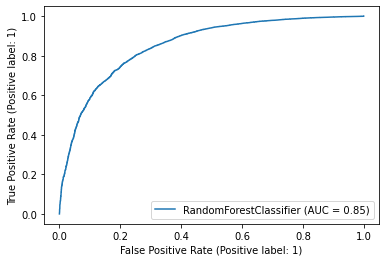

In [25]:
plot_roc_curve(model, X_test, y_test)

# ScoreCard method

## Feature selection

In [6]:
df_score_card = copy.deepcopy(df_original)
cols = df_score_card.iloc[:,1:].columns

In [7]:
# This is to bin each feature to 10 equally sized bins. If not possible, reduce the number of bins until a binning is possible.
# After binning, a dictionary bin_boundary is saved to store {col: [(min, max, bin_name)]}

bin_boundary = {}
for col in cols:
    mask = ~df_score_card[col].isna()
    cut, bin = pd.qcut(df_score_card.loc[mask, col], q=6
            , duplicates='drop', retbins=True)
    bin_min = [-np.inf] + list(bin[1:-1])
    bin_max = list(bin[1:-1]) + [np.inf]
    bin_range = list(zip(bin_min, bin_max))
    bin_name = [f'{col}({min} ,{max}]' for (min,max) in bin_range]
    cut = pd.qcut(df_score_card.loc[mask, col], q=6, duplicates='drop', labels=bin_name)
    bin_boundary[col] = list(zip(bin_min, bin_max, bin_name))
    df_score_card.loc[mask, col] = [i for i in cut]
    df_score_card.loc[~mask, col] = col + '(missing]'

In [8]:
# This is to calculate the woe and IV of each column
def woe_check(df, col):
    df_2col = pd.crosstab(df[col],df['SeriousDlqin2yrs']).reset_index()
    df_2col.columns = ['Feature', 'Bad count', 'Good count']
    df_2col['Total count'] = df_2col['Good count'] + df_2col['Bad count']
    df_2col['Total distribution'] = df_2col['Total count']/df_2col['Total count'].sum()
    df_2col['Good distribution'] = df_2col['Good count']/df_2col['Good count'].sum()
    df_2col['Bad distribution'] = df_2col['Bad count']/df_2col['Bad count'].sum()
    df_2col['WOE'] = np.log(df_2col['Good distribution']/df_2col['Bad distribution'])
    IV = ((df_2col['Good distribution'] - df_2col['Bad distribution']) * df_2col['WOE']).sum()
    df_2col['IV'] = IV
    return(df_2col, IV)


In [9]:
# to select columns with IV between 0.02 and 0.6
selected_cols = []
woe_df = pd.DataFrame()
for col in cols:
    woe_summary, IV = woe_check(df_score_card,col)
    if (0.02<IV 
        # and IV<0.6
        ):
        woe_df = pd.concat([woe_df, woe_summary[['Feature', 'WOE']]])
        display(woe_summary.head(5))
        selected_cols.append(col)
selected_cols

,Feature,Bad count,Good count,Total count,Total distribution,Good distribution,Bad distribution,WOE,IV
0,"RevolvingUtilizationOfUnsecuredLines(-inf ,0.0...",510,24490,25000,0.166667,0.174961,0.050868,1.235334,1.079666
1,RevolvingUtilizationOfUnsecuredLines(0.0130977...,367,24633,25000,0.166667,0.175983,0.036605,1.570205,1.079666
2,RevolvingUtilizationOfUnsecuredLines(0.0544198...,558,24442,25000,0.166667,0.174618,0.055655,1.143424,1.079666
3,RevolvingUtilizationOfUnsecuredLines(0.1541807...,998,24002,25000,0.166667,0.171475,0.099541,0.543864,1.079666
4,RevolvingUtilizationOfUnsecuredLines(0.3799454...,2316,22684,25000,0.166667,0.162059,0.230999,-0.354457,1.079666


,Feature,Bad count,Good count,Total count,Total distribution,Good distribution,Bad distribution,WOE,IV
0,"age(-inf ,37.0]",2855,23531,26386,0.175907,0.168110,0.284760,-0.527028,0.253018
1,"age(37.0 ,45.0]",2164,22755,24919,0.166127,0.162566,0.215839,-0.283448,0.253018
2,"age(45.0 ,52.0]",2058,24007,26065,0.173767,0.171510,0.205266,-0.179664,0.253018
3,"age(52.0 ,59.0]",1449,22863,24312,0.162080,0.163337,0.144524,0.122371,0.253018
4,"age(59.0 ,67.0]",969,23747,24716,0.164773,0.169653,0.096649,0.562672,0.253018


,Feature,Bad count,Good count,Total count,Total distribution,Good distribution,Bad distribution,WOE,IV
0,"DebtRatio(-inf ,0.10332816666666667]",1487,23513,25000,0.166667,0.167981,0.148314,0.124518,0.045979
1,"DebtRatio(0.10332816666666667 ,0.2381924556666...",1532,23468,25000,0.166667,0.167660,0.152803,0.092789,0.045979
2,"DebtRatio(0.23819245566666664 ,0.366507841]",1369,23631,25000,0.166667,0.168824,0.136545,0.212204,0.045979
3,"DebtRatio(0.366507841 ,0.5699383023333333]",1808,23192,25000,0.166667,0.165688,0.180331,-0.084689,0.045979
4,"DebtRatio(0.5699383023333333 ,76.0]",2393,22619,25012,0.166747,0.161594,0.238679,-0.390033,0.045979


,Feature,Bad count,Good count,Total count,Total distribution,Good distribution,Bad distribution,WOE,IV
0,"MonthlyIncome(-inf ,2700.0]",1808,18482,20290,0.135267,0.132039,0.180331,-0.311699,0.071328
1,"MonthlyIncome(2700.0 ,4000.0]",1818,18290,20108,0.134053,0.130667,0.181329,-0.327658,0.071328
2,"MonthlyIncome(4000.0 ,5400.0]",1525,18392,19917,0.132780,0.131396,0.152105,-0.146354,0.071328
3,"MonthlyIncome(5400.0 ,7080.0]",1270,18600,19870,0.132467,0.132882,0.126671,0.047870,0.071328
4,"MonthlyIncome(7080.0 ,9908.333333333328]",1066,18973,20039,0.133593,0.135547,0.106324,0.242829,0.071328


,Feature,Bad count,Good count,Total count,Total distribution,Good distribution,Bad distribution,WOE,IV
0,"NumberOfOpenCreditLinesAndLoans(-inf ,4.0]",3103,30556,33659,0.224393,0.218298,0.309495,-0.349083,0.050379
1,"NumberOfOpenCreditLinesAndLoans(10.0 ,13.0]",1222,19771,20993,0.139953,0.141248,0.121883,0.147452,0.050379
2,"NumberOfOpenCreditLinesAndLoans(13.0 ,inf]",1537,20480,22017,0.146780,0.146313,0.153301,-0.046659,0.050379
3,"NumberOfOpenCreditLinesAndLoans(4.0 ,6.0]",1573,24972,26545,0.176967,0.178405,0.156892,0.128496,0.050379
4,"NumberOfOpenCreditLinesAndLoans(6.0 ,8.0]",1353,24454,25807,0.172047,0.174704,0.134949,0.258194,0.050379


,Feature,Bad count,Good count,Total count,Total distribution,Good distribution,Bad distribution,WOE,IV
0,"NumberOfDependents(-inf ,1.0]",7030,106188,113218,0.754787,0.758627,0.701177,0.078749,0.027233
1,"NumberOfDependents(1.0 ,2.0]",1584,17938,19522,0.130147,0.128152,0.157989,-0.209307,0.027233
2,"NumberOfDependents(2.0 ,inf]",1233,12103,13336,0.088907,0.086466,0.122980,-0.352272,0.027233
3,NumberOfDependents(missing],179,3745,3924,0.026160,0.026755,0.017854,0.404516,0.027233


['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents']

In [10]:
woe_dict = woe_df.set_index('Feature').to_dict()['WOE']

In [11]:
woe_df['Original Feature'] = woe_df['Feature'].str.split('(').str[0]
woe_df.columns = ['Derived feature', 'WOE', 'Feature']
woe_df

,Derived feature,WOE,Feature
0,"RevolvingUtilizationOfUnsecuredLines(-inf ,0.0...",1.235334,RevolvingUtilizationOfUnsecuredLines
1,RevolvingUtilizationOfUnsecuredLines(0.0130977...,1.570205,RevolvingUtilizationOfUnsecuredLines
2,RevolvingUtilizationOfUnsecuredLines(0.0544198...,1.143424,RevolvingUtilizationOfUnsecuredLines
3,RevolvingUtilizationOfUnsecuredLines(0.1541807...,0.543864,RevolvingUtilizationOfUnsecuredLines
4,RevolvingUtilizationOfUnsecuredLines(0.3799454...,-0.354457,RevolvingUtilizationOfUnsecuredLines
5,RevolvingUtilizationOfUnsecuredLines(0.8025828...,-1.317847,RevolvingUtilizationOfUnsecuredLines
0,"age(-inf ,37.0]",-0.527028,age
1,"age(37.0 ,45.0]",-0.283448,age
2,"age(45.0 ,52.0]",-0.179664,age
3,"age(52.0 ,59.0]",0.122371,age


In [12]:
for col in df_score_card.iloc[:,1:].columns:
    df_score_card[col] = df_score_card[col].map(woe_dict)

In [13]:
df_score_card

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,-0.354457,-0.283448,NaN,-0.390033,0.242829,0.147452,NaN,NaN,NaN,-0.209307
1,1,-1.317847,-0.283448,NaN,0.092789,-0.311699,-0.349083,NaN,NaN,NaN,0.078749
2,1,-0.354457,-0.283448,NaN,0.124518,-0.327658,-0.349083,NaN,NaN,NaN,0.078749
3,1,0.543864,-0.527028,NaN,0.124518,-0.327658,0.128496,NaN,NaN,NaN,0.078749
4,1,-1.317847,-0.179664,NaN,0.124518,0.456594,0.258194,NaN,NaN,NaN,0.078749
...,...,...,...,...,...,...,...,...,...,...,...
149995,1,1.570205,1.135295,NaN,0.092789,-0.311699,-0.349083,NaN,NaN,NaN,0.078749
149996,1,0.543864,-0.283448,NaN,-0.390033,0.047870,-0.349083,NaN,NaN,NaN,-0.209307
149997,1,0.543864,0.122371,NaN,0.160336,0.185917,-0.046659,NaN,NaN,NaN,0.078749
149998,1,1.235334,-0.527028,NaN,0.124518,0.047870,-0.349083,NaN,NaN,NaN,0.078749


## Classification pipeline

In [14]:
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, bin_boundary=bin_boundary, selected_cols = selected_cols): # no *args or *kargs
        self.bin_boundary = bin_boundary
        self.selected_cols = selected_cols

    #utility function
    def categorise(self,value, bin_list):
        for (min, max, category) in bin_list:
            if (value > min) and (value <= max):
                return category

    def fit(self, X, y = None):
        return self #nothing else to do
        
    def transform(self, X):
        X_new = X[self.selected_cols]
        for k,v in self.bin_boundary.items():
            if k in self.selected_cols:
                X_new[k] = X_new[k].map(lambda  x: self.categorise(x, bin_boundary[k]))
                X_new[k] = X_new[k].fillna(f'{k}(missing]')
        for col in self.selected_cols:
            X_new[col] = X_new[col].map(woe_dict)
        return X_new

In [15]:
df_score_card = copy.deepcopy(df_original)

In [16]:
X = df_score_card.iloc[:,1:]
y = df_score_card.iloc[:,0]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [19]:
sampler = imblearn.over_sampling.SMOTE(sampling_strategy='minority')
woe_transform = WoE_Binning()
reg = LogisticRegression(max_iter=1000)

pipeline = imbpipeline(steps = [['woe', woe_transform],
                                ['sampler', sampler],
                                ['classifier', reg]])

In [20]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('woe', WoE_Binning()),
                ('sampler', SMOTE(sampling_strategy='minority')),
                ['classifier', LogisticRegression(max_iter=1000)]])

In [21]:
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:,1]

In [22]:
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_prob)

(0.7146666666666667, 0.7830042329007778)

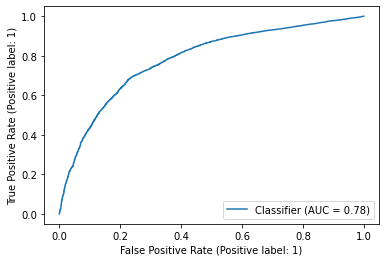

In [23]:
RocCurveDisplay.from_predictions(y_test, y_pred_prob)

## Scorecard creating

In [24]:
pipeline['woe'].transform(X_test)

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
16269,1.143424,0.122371,0.160336,0.185917,0.147452,0.404516
140471,-1.317847,-0.283448,0.160336,0.185917,-0.349083,0.078749
78683,0.543864,-0.179664,-0.390033,-0.146354,0.258194,0.078749
2605,0.543864,0.562672,-0.390033,-0.146354,-0.046659,0.078749
81156,-0.354457,-0.527028,-0.390033,-0.311699,0.258194,0.078749
...,...,...,...,...,...,...
8727,-0.354457,-0.527028,0.124518,-0.311699,-0.349083,0.078749
138804,-0.354457,-0.179664,0.212204,0.047870,0.147452,-0.209307
135967,0.543864,1.135295,-0.084689,-0.146354,0.132926,0.078749
105000,-1.317847,-0.283448,-0.084689,0.456594,0.147452,0.078749


In [25]:
coefs = np.concatenate(([pipeline['classifier'].intercept_[0]], pipeline['classifier'].coef_[0]))
feature_names = np.concatenate((['Intercept'], pipeline['woe'].transform(X_train).columns))

In [26]:
score_card = pd.DataFrame(list(zip(feature_names, coefs)), columns=['Feature', 'Coef'])
score_card

,Feature,Coef
0,Intercept,0.008514
1,RevolvingUtilizationOfUnsecuredLines,0.925743
2,age,0.478786
3,DebtRatio,0.743492
4,MonthlyIncome,0.410096
5,NumberOfOpenCreditLinesAndLoans,0.093459
6,NumberOfDependents,0.296212


In [27]:
score_card = pd.merge(score_card, woe_df, on='Feature', how='outer')

In [28]:
pdo = 20
target_score = 600
target_step = 50

factor = pdo/np.log(2)
offset = target_score - factor * np.log(target_step)
n = score_card['Feature'].nunique()-1
intercept = score_card.loc[score_card['Feature']=='Intercept','Coef'].values[0]

In [30]:
score_card['Score'] = round((score_card['Coef'] * score_card['WOE'] + intercept/n) * factor + offset/n)
score_card['Odd_increase'] = np.exp(score_card['Coef'])

In [31]:
score_card.head(5)

,Feature,Coef,Derived feature,WOE,Score,Odd_increase
0,Intercept,0.008514,NaN,NaN,NaN,1.008550
1,RevolvingUtilizationOfUnsecuredLines,0.925743,"RevolvingUtilizationOfUnsecuredLines(-inf ,0.0...",1.235334,114.0,2.523743
2,RevolvingUtilizationOfUnsecuredLines,0.925743,RevolvingUtilizationOfUnsecuredLines(0.0130977...,1.570205,123.0,2.523743
3,RevolvingUtilizationOfUnsecuredLines,0.925743,RevolvingUtilizationOfUnsecuredLines(0.0544198...,1.143424,112.0,2.523743
4,RevolvingUtilizationOfUnsecuredLines,0.925743,RevolvingUtilizationOfUnsecuredLines(0.1541807...,0.543864,96.0,2.523743


In [32]:
score_card[['Derived feature', 'Score']].to_excel('Scorecard.xlsx', index=False)

In [33]:
score_card_dict = dict(zip(score_card['Derived feature'], score_card['Score']))

In [34]:
pipeline['woe'].transform(X)

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
0,-0.354457,-0.283448,-0.390033,0.242829,0.147452,-0.209307
1,-1.317847,-0.283448,0.092789,-0.311699,-0.349083,0.078749
2,-0.354457,-0.283448,0.124518,-0.327658,-0.349083,0.078749
3,0.543864,-0.527028,0.124518,-0.327658,0.128496,0.078749
4,-1.317847,-0.179664,0.124518,0.456594,0.258194,0.078749
...,...,...,...,...,...,...
149995,1.570205,1.135295,0.092789,-0.311699,-0.349083,0.078749
149996,0.543864,-0.283448,-0.390033,0.047870,-0.349083,-0.209307
149997,0.543864,0.122371,0.160336,0.185917,-0.046659,0.078749
149998,1.235334,-0.527028,0.124518,0.047870,-0.349083,0.078749


In [92]:
X_transformed = pd.DataFrame()
for col in selected_cols:
    X_transformed[col] = X[col].apply(lambda x: woe_transform.categorise(x, bin_list=bin_boundary[col]))
for col in selected_cols:
    X_transformed[col] = X_transformed[col].fillna(f'{col}(missing]')
X_transformed['prob_good'] = reg.predict_proba(woe_transform.transform(X))[:,1]
X_transformed['log_odd_good'] = reg.predict_log_proba(woe_transform.transform(X))[:,1]-reg.predict_log_proba(woe_transform.transform(X))[:,0]
X_transformed['odd_good'] = np.exp(X_transformed['log_odd_good'])
X_transformed['Score_naive'] = offset + factor * X_transformed['log_odd_good']
X_transformed = pd.concat([y,X_transformed], axis=1)
X_transformed.head(10)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,prob_good,log_odd_good,odd_good,Score_naive
0,0,RevolvingUtilizationOfUnsecuredLines(0.3799454...,"age(37.0 ,45.0]","DebtRatio(0.5699383023333333 ,76.0]","MonthlyIncome(7080.0 ,9908.333333333328]","NumberOfOpenCreditLinesAndLoans(10.0 ,13.0]","NumberOfDependents(1.0 ,2.0]",0.875017,1.946066,7.001094,543.274482
1,1,RevolvingUtilizationOfUnsecuredLines(0.8025828...,"age(37.0 ,45.0]","DebtRatio(0.10332816666666667 ,0.2381924556666...","MonthlyIncome(-inf ,2700.0]","NumberOfOpenCreditLinesAndLoans(-inf ,4.0]","NumberOfDependents(-inf ,1.0]",0.772931,1.224937,3.403952,522.467086
2,1,RevolvingUtilizationOfUnsecuredLines(0.3799454...,"age(37.0 ,45.0]","DebtRatio(-inf ,0.10332816666666667]","MonthlyIncome(2700.0 ,4000.0]","NumberOfOpenCreditLinesAndLoans(-inf ,4.0]","NumberOfDependents(-inf ,1.0]",0.894616,2.138780,8.489077,548.835030
3,1,RevolvingUtilizationOfUnsecuredLines(0.1541807...,"age(-inf ,37.0]","DebtRatio(-inf ,0.10332816666666667]","MonthlyIncome(2700.0 ,4000.0]","NumberOfOpenCreditLinesAndLoans(4.0 ,6.0]","NumberOfDependents(-inf ,1.0]",0.949690,2.937933,18.876791,571.893709
4,1,RevolvingUtilizationOfUnsecuredLines(0.8025828...,"age(45.0 ,52.0]","DebtRatio(-inf ,0.10332816666666667]","MonthlyIncome(9908.333333333328 ,inf]","NumberOfOpenCreditLinesAndLoans(6.0 ,8.0]","NumberOfDependents(-inf ,1.0]",0.838146,1.644501,5.178426,534.573150
5,1,RevolvingUtilizationOfUnsecuredLines(0.1541807...,"age(67.0 ,inf]","DebtRatio(0.366507841 ,0.5699383023333333]","MonthlyIncome(2700.0 ,4000.0]","NumberOfOpenCreditLinesAndLoans(-inf ,4.0]","NumberOfDependents(-inf ,1.0]",0.970180,3.482291,32.534175,587.600558
6,1,RevolvingUtilizationOfUnsecuredLines(0.1541807...,"age(52.0 ,59.0]","DebtRatio(76.0 ,inf]",MonthlyIncome(missing],"NumberOfOpenCreditLinesAndLoans(6.0 ,8.0]","NumberOfDependents(-inf ,1.0]",0.969330,3.453331,31.605503,586.764954
7,1,RevolvingUtilizationOfUnsecuredLines(0.3799454...,"age(37.0 ,45.0]","DebtRatio(0.10332816666666667 ,0.2381924556666...","MonthlyIncome(2700.0 ,4000.0]","NumberOfOpenCreditLinesAndLoans(6.0 ,8.0]","NumberOfDependents(-inf ,1.0]",0.901391,2.212775,9.141050,550.970073
8,1,RevolvingUtilizationOfUnsecuredLines(0.0544198...,"age(-inf ,37.0]","DebtRatio(0.5699383023333333 ,76.0]",MonthlyIncome(missing],"NumberOfOpenCreditLinesAndLoans(-inf ,4.0]",NumberOfDependents(missing],0.965319,3.326279,27.834564,583.098987
9,1,RevolvingUtilizationOfUnsecuredLines(0.1541807...,"age(52.0 ,59.0]","DebtRatio(0.5699383023333333 ,76.0]","MonthlyIncome(9908.333333333328 ,inf]","NumberOfOpenCreditLinesAndLoans(8.0 ,10.0]","NumberOfDependents(1.0 ,2.0]",0.954249,3.037717,20.857562,574.772849


In [78]:
X_scored = copy.deepcopy(X_transformed)
for col in selected_cols:
    X_scored[col] = X_scored[col].map(score_card_dict)

X_scored['Score'] = X_scored.iloc[:,0:6].sum(axis=1)
X_scored.head(20)



,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,prob_good,log_odd_good,odd_good,Score_naive,Score
0,84.0,90.0,86.0,96.0,95.0,92.0,0.875017,1.946066,7.001094,543.274482,543.0
1,59.0,90.0,96.0,91.0,92.0,95.0,0.772931,1.224937,3.403952,522.467086,523.0
2,84.0,90.0,96.0,91.0,92.0,95.0,0.894616,2.138780,8.489077,548.835030,548.0
3,109.0,87.0,96.0,91.0,95.0,95.0,0.949690,2.937933,18.876791,571.893709,573.0
4,59.0,92.0,96.0,98.0,95.0,95.0,0.838146,1.644501,5.178426,534.573150,535.0
5,109.0,109.0,92.0,91.0,92.0,95.0,0.970180,3.482291,32.534175,587.600558,588.0
6,109.0,96.0,97.0,96.0,95.0,95.0,0.969330,3.453331,31.605503,586.764954,588.0
7,84.0,90.0,96.0,91.0,95.0,95.0,0.901391,2.212775,9.141050,550.970073,551.0
8,125.0,87.0,86.0,96.0,92.0,98.0,0.965319,3.326279,27.834564,583.098987,584.0
9,109.0,96.0,86.0,98.0,95.0,92.0,0.954249,3.037717,20.857562,574.772849,576.0


<AxesSubplot:xlabel='SeriousDlqin2yrs', ylabel='Score'>

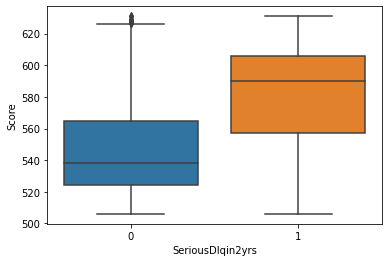

In [79]:
sns.boxplot(x=y,y=X_scored['Score'])

<AxesSubplot:xlabel='Score', ylabel='Count'>

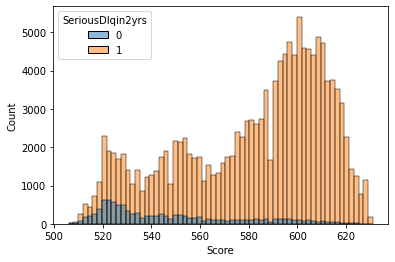

In [94]:
sns.histplot(x=X_scored['Score'], hue=y)

<AxesSubplot:xlabel='prob_good', ylabel='Count'>

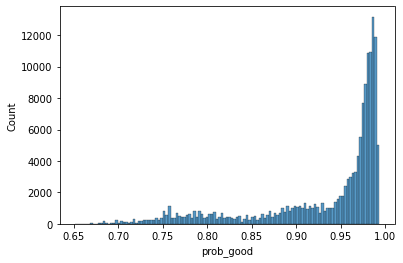

In [80]:
sns.histplot(X_scored['prob_good'])

# Prediction

In [58]:
prod_df = pd.read_csv('cs-test.csv').drop(columns='Unnamed: 0')

In [59]:
X_prod = prod_df.iloc[:,1:]

In [60]:
pipeline.predict_proba(X_prod)[:,1]

array([0.21980692, 0.43111923, 0.75608328, ..., 0.86366955, 0.66684432,
       0.38969092])

In [61]:
X_prod_transformed = pd.DataFrame()
for col in selected_cols:
    X_prod_transformed[col] = X_prod[col].apply(lambda x: woe_transform.categorise(x, bin_list=bin_boundary[col]))
for col in selected_cols:
    X_prod_transformed[col] = X_prod_transformed[col].fillna(f'{col}(missing]')
X_prod_transformed['prob_good'] = reg.predict_proba(woe_transform.transform(X_prod))[:,1]
X_prod_transformed['log_odd_good'] = reg.predict_log_proba(woe_transform.transform(X_prod))[:,1]-reg.predict_log_proba(woe_transform.transform(X_prod))[:,0]
X_prod_transformed['odd_good'] = np.exp(X_prod_transformed['log_odd_good'])
# X_prod_transformed['Score_naive'] = offset + factor * X_prod_transformed['log_odd_good']
X_prod_scored = copy.deepcopy(X_prod_transformed)
for col in selected_cols:
    X_prod_scored[col] = X_prod_scored[col].map(score_card_dict)

X_prod_scored['Score'] = X_prod_scored.iloc[:,0:6].sum(axis=1)
X_prod_scored.head(20)


,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,prob_good,log_odd_good,odd_good,Score
0,59.0,90.0,96.0,94.0,92.0,95.0,0.219807,-1.266792,0.281734,526.0
1,84.0,96.0,92.0,96.0,94.0,92.0,0.431119,-0.277286,0.757838,554.0
2,136.0,96.0,86.0,93.0,95.0,92.0,0.756083,1.131325,3.099760,598.0
3,109.0,90.0,86.0,91.0,95.0,95.0,0.499148,-0.003408,0.996598,566.0
4,59.0,87.0,96.0,91.0,92.0,95.0,0.179860,-1.517297,0.219304,520.0
5,84.0,101.0,98.0,93.0,92.0,95.0,0.503848,0.015394,1.015513,563.0
6,84.0,92.0,97.0,91.0,95.0,91.0,0.377821,-0.498808,0.607254,550.0
7,136.0,109.0,92.0,91.0,95.0,95.0,0.860217,1.817093,6.153943,618.0
8,136.0,109.0,97.0,96.0,92.0,95.0,0.896816,2.162335,8.691408,625.0
9,59.0,87.0,96.0,91.0,92.0,95.0,0.180870,-1.510462,0.220808,520.0


In [62]:
prod_df['Score'] = X_prod_scored['Score']
prod_df['PD'] = 1 - X_prod_scored['prob_good']

In [63]:
prod_df.to_csv('cs-test_scored.csv')

In [64]:
prod_df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Score,PD
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,526.0,0.780193
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,554.0,0.568881
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,598.0,0.243917
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,566.0,0.500852
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,520.0,0.820140


# Scorecard pipepline

In [36]:
with open('pipeline.pkl', 'wb') as f:
    pickle.dump((pipeline, selected_cols), f)

In [40]:
def create_score(file_name):
    prod_df = pd.read_csv(file_name).drop(columns='Unnamed: 0')
    X_prod = prod_df.iloc[:,1:]
    pipeline.predict_proba(X_prod)[:,1]
    X_prod_transformed = pd.DataFrame()
    for col in selected_cols:
        X_prod_transformed[col] = X_prod[col].apply(lambda x: woe_transform.categorise(x, bin_list=bin_boundary[col]))
    for col in selected_cols:
        X_prod_transformed[col] = X_prod_transformed[col].fillna(f'{col}(missing]')
    X_prod_transformed['prob_good'] = reg.predict_proba(woe_transform.transform(X_prod))[:,1]
    X_prod_transformed['log_odd_good'] = reg.predict_log_proba(woe_transform.transform(X_prod))[:,1]-reg.predict_log_proba(woe_transform.transform(X_prod))[:,0]
    X_prod_transformed['odd_good'] = np.exp(X_prod_transformed['log_odd_good'])
    X_prod_scored = copy.deepcopy(X_prod_transformed)
    for col in selected_cols:
        X_prod_scored[col] = X_prod_scored[col].map(score_card_dict)

    X_prod_scored['Score'] = X_prod_scored.iloc[:,0:6].sum(axis=1)
    X_prod_scored.head(20)

    prod_df['Score'] = X_prod_scored['Score']
    prod_df['PD'] = 1 - X_prod_scored['prob_good']
    return prod_df

In [41]:
create_score('cs-test.csv')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Score,PD
0,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,450.0,0.780377
1,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,478.0,0.572186
2,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,519.0,0.245550
3,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,487.0,0.500155
4,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,443.0,0.819786
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101498,NaN,0.282653,24,0,0.068522,1400.0,5,0,0,0,0.0,496.0,0.435426
101499,NaN,0.922156,36,3,0.934217,7615.0,8,0,2,0,4.0,437.0,0.849978
101500,NaN,0.081596,70,0,836.000000,NaN,3,0,0,0,NaN,542.0,0.130875
101501,NaN,0.335457,56,0,3568.000000,NaN,8,0,2,1,3.0,507.0,0.334964
